# Embeddings

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

#Import Warnings
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [4]:
df = pd.read_csv('useritemsmelt.csv', index_col=0)
df = df.rename(columns = {'variable':'iid', 'value': 'owned'})
df.head()

,uid,iid,owned
0,0,10,0.0
1,1,10,0.0
2,2,10,0.0
3,3,10,1.0
4,4,10,0.0


In [5]:
n_games = len(df.iid.unique())
n_users = len(df.uid.unique())
print(
    "{1:,} distinct users rated {0:,} different games (total ratings = {2:,})".format(
        n_games, n_users, len(df),
    )
)

6,352 distinct users rated 9,054 different games (total ratings = 57,511,008)


## NN model

In [12]:
hidden_units = (32,4)
game_embedding_size = 8
user_embedding_size = 8

# Each instance will consist of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
game_id_input = keras.Input(shape=(1,), name='game_id')
user_embedded = keras.layers.Embedding(df.uid.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
game_embedded = keras.layers.Embedding(df.iid.max()+1, game_embedding_size, 
                                        input_length=1, name='game_embedding')(game_id_input)

# Concatenate the embeddings (and remove the useless extra dimension)
concatenated = keras.layers.Concatenate()([user_embedded, game_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)
    
# A single output: our prediction
out = keras.layers.Dense(1, activation='sigmoid', name='prediction')(out)

# Build model
model = keras.Model(
    inputs = [user_id_input, game_id_input],
    outputs = out,
)

model.summary(line_length=88)

Model: "model"
________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
user_id (InputLayer)         [(None, 1)]        0                                       
________________________________________________________________________________________
game_id (InputLayer)         [(None, 1)]        0                                       
________________________________________________________________________________________
user_embedding (Embedding)   (None, 1, 8)       50816     user_id[0][0]                 
________________________________________________________________________________________
game_embedding (Embedding)   (None, 1, 8)       4229288   game_id[0][0]                 
________________________________________________________________________________________
concatenate_1 (Concatenate)  (None, 1, 16)      0         user_embedding[0][0]          
      

In [14]:
# Compile model
model.compile(
    tf.optimizers.Adam(0.005),
    loss='MSE',
    metrics=['MAE'],
)

In [15]:
# Train model
history = model.fit(
    [df.uid, df.iid],
    df.owned,
    batch_size=5000,
    epochs=10,
    verbose=0,
    validation_split=.05,
)

In [24]:
history.history.keys()

dict_keys(['loss', 'MAE', 'val_loss', 'val_MAE'])

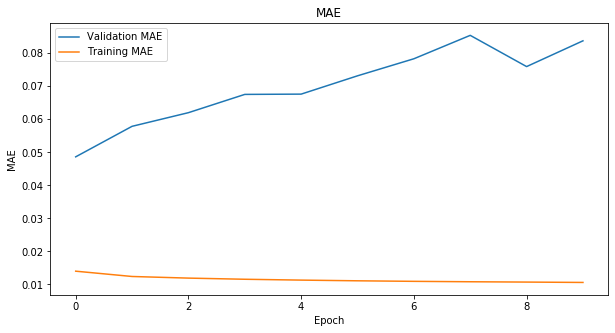

In [25]:
plt.figure(figsize=(10,5))
plt.plot(history.history['val_MAE'], label = 'Validation MAE')
plt.plot(history.history['MAE'], label = 'Training MAE')
plt.legend()
plt.title('MAE')
plt.xlabel('Epoch')b
plt.ylabel('MAE')
plt.show()

## Example predictions

In [30]:
user_ratings = df[df.uid==50]
print("User #{} has rated {} movies (avg. rating = {:.1f}):".format(
    50, len(user_ratings), user_ratings['owned'].mean(),
))
cols = ['uid', 'iid', 'owned']
user_ratings.sort_values(by='owned', ascending=False)[cols]

User #50 has rated 9054 movies (avg. rating = 0.0):


,uid,iid,owned
50,50,10,1.0
54976610,50,550,1.0
17245730,50,291550,1.0
2756818,50,202710,1.0
2801282,50,203160,1.0
...,...,...,...
19354594,50,302130,0.0
19348242,50,302120,0.0
19341890,50,302110,0.0
19335538,50,302080,0.0
